In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [15]:
tokenizer_path="Bllossom/llama-3.2-Korean-Bllossom-3B"
use_local_files=False
cache_dir="PATH/TO/CACHE/DIR"

text_tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_path,
    local_files_only=use_local_files,
    trust_remote_code=True,
    cache_dir=cache_dir,
)

In [3]:
lang_encoder_path="Bllossom/llama-3.2-Korean-Bllossom-3B"

lang_encoder = AutoModelForCausalLM.from_pretrained(
    lang_encoder_path,
    local_files_only=use_local_files,
    torch_dtype = torch.float16,
    trust_remote_code=True,
    cache_dir=cache_dir,
)

/home/hanseungsoo/miniconda3/envs/openflamingo/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/hanseungsoo/miniconda3/envs/openflamingo/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user fe

In [4]:
from open_flamingo.src.flamingo_lm import FlamingoLMMixin
from open_flamingo.src.utils import extend_instance
import torch.nn as nn
from open_flamingo.src.helpers import GatedCrossAttentionBlock
from open_flamingo.src.utils import getattr_recursive, setattr_recursive

In [6]:
lang_encoder

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): L

In [5]:
extend_instance(lang_encoder, FlamingoLMMixin)

In [8]:
__KNOWN_DECODER_LAYERS_ATTR_NAMES = {
    "opt": "model.decoder.layers",
    "gptj": "transformer.h",
    "gpt-j": "transformer.h",
    "pythia": "gpt_neox.layers",
    "llama": "model.layers",
    "gptneoxforcausallm": "gpt_neox.layers",
    "mpt": "transformer.blocks",
    "mosaicgpt": "transformer.blocks",
}

In [9]:
def _infer_decoder_layers_attr_name(model):
    for k in __KNOWN_DECODER_LAYERS_ATTR_NAMES:
        if k.lower() in model.__class__.__name__.lower():
            return __KNOWN_DECODER_LAYERS_ATTR_NAMES[k]

decoder_layers_attr_name = _infer_decoder_layers_attr_name(lang_encoder)
lang_encoder.set_decoder_layers_attr_name(decoder_layers_attr_name)

In [9]:
decoder_layers_attr_name

'model.layers'

: 

In [6]:
gated_cross_attn_layers = nn.ModuleList([GatedCrossAttentionBlock(
                    dim=3072, dim_visual=1024
                )
for layer_idx in enumerate(lang_encoder.model.layers)])

: 

In [11]:
old_decoder_blocks = lang_encoder.model.layers

In [12]:
class FlamingoLayer(nn.Module):
    """
    FlamingoLayer is a wrapper around the GatedCrossAttentionBlock and DecoderLayer.
    """

    def __init__(
        self, gated_cross_attn_layer, decoder_layer, gradient_checkpointing=False
    ):
        super().__init__()
        self.gated_cross_attn_layer = gated_cross_attn_layer
        self.decoder_layer = decoder_layer
        self.vis_x = None
        self.media_locations = None
        if self.gated_cross_attn_layer is not None:
            self.gated_cross_attn_layer._use_gradient_checkpointing = (
                gradient_checkpointing
            )
        self.decoder_layer._use_gradient_checkpointing = gradient_checkpointing

    def is_conditioned(self) -> bool:
        """Check whether the layer is conditioned."""
        return self.vis_x is not None and self.media_locations is not None

    # Used this great idea from this implementation of Flamingo (https://github.com/dhansmair/flamingo-mini/)
    def condition_vis_x(self, vis_x):
        self.vis_x = vis_x

    def condition_media_locations(self, media_locations):
        self.media_locations = media_locations

    def condition_use_cached_media(self, use_cached_media):
        self.use_cached_media = use_cached_media

    def forward(
        self,
        lang_x,
        attention_mask=None,
        **decoder_layer_kwargs,
    ):
        # Cross attention
        if self.gated_cross_attn_layer is not None:
            if self.vis_x is None:
                raise ValueError("vis_x must be conditioned before forward pass")

            if self.media_locations is None:
                raise ValueError(
                    "media_locations must be conditioned before forward pass"
                )

            lang_x = self.gated_cross_attn_layer(
                lang_x,
                self.vis_x,
                media_locations=self.media_locations,
                use_cached_media=self.use_cached_media,
            )

        # Normal decoder layer
        lang_x = self.decoder_layer(
            lang_x, attention_mask=attention_mask, **decoder_layer_kwargs
        )
        return lang_x

In [13]:
nn.ModuleList(
                [
                    FlamingoLayer(
                        gated_cross_attn_layer, decoder_layer, gradient_checkpointing=False
                    )
                    for gated_cross_attn_layer, decoder_layer in zip(
                        gated_cross_attn_layers, old_decoder_blocks
                    )
                ]
            )

ModuleList(
  (0-27): 28 x FlamingoLayer(
    (gated_cross_attn_layer): GatedCrossAttentionBlock(
      (attn): MaskedCrossAttention(
        (norm): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
        (to_q): Linear(in_features=3072, out_features=512, bias=False)
        (to_kv): Linear(in_features=1024, out_features=1024, bias=False)
        (to_out): Linear(in_features=512, out_features=3072, bias=False)
      )
      (ff): Sequential(
        (0): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=3072, out_features=12288, bias=False)
        (2): GELU(approximate='none')
        (3): Linear(in_features=12288, out_features=3072, bias=False)
      )
    )
    (decoder_layer): LlamaDecoderLayer(
      (self_attn): LlamaAttention(
        (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
        (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (v_proj): Linear(in_features=3072, out_features=1024, b

: 

In [18]:
from datasets import load_dataset

ds = load_dataset("Bingsu/laion2B-multi-korean-subset",
                    cache_dir="PATH/TO/CACHE/DIR",
                    )

print(ds)

DatasetDict({
    train: Dataset({
        features: ['SAMPLE_ID', 'URL', 'TEXT', 'HEIGHT', 'WIDTH', 'LICENSE', 'LANGUAGE', 'NSFW', 'similarity'],
        num_rows: 11376263
    })
})


'https://moviekece.com/wp-content/uploads/2020/11/Nonton-Film-The-Swordsman-2020-Sub-Indo-200x112.jpg'

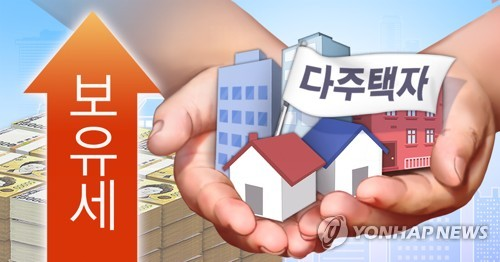

In [13]:


url = ds['train']['URL'][0]
res = requests.get(url)

img = Image.open(BytesIO(res.content))
img

In [13]:
from torch.utils.data import Dataset
from torchvision.transforms.functional import pil_to_tensor
import requests
from io import BytesIO
from PIL import Image
from datasets import load_dataset
import re

class ko_Laion(Dataset):
    def __init__(self,transform=False):
        super().__init__()
        self.ds = load_dataset("Bingsu/laion2B-multi-korean-subset",
                    cache_dir="PATH/TO/CACHE/DIR",
                    )
        self.url = self.ds['train']['URL']
        self.text = self.ds['train']['TEXT']
        self.transform = transform
    
    def __getitem__(self,idx):
        image_url = self.url[idx]
        text = self.text[idx]

        res = requests.get(image_url)

        img = Image.open(BytesIO(res.content))
    

        if self.transform:
            img = self.transform(img)
            
        img = pil_to_tensor(img)
        return img, text
    
    def __len__(self):
        return len(self.url)

In [14]:
dataset = ko_Laion()

In [16]:
import os
os.getcwd()

'/home/hanseungsoo/project/Flamin-Ko/open_flamingo/open_flamingo'

Creating CSV from Arrow format: 100%|██████████| 11377/11377 [00:39<00:00, 291.29ba/s]


2520688383

In [20]:
import pandas as pd
pd.read_csv('korean-laion2B.csv').columns

Index(['SAMPLE_ID', 'URL', 'TEXT', 'HEIGHT', 'WIDTH', 'LICENSE', 'LANGUAGE',
       'NSFW', 'similarity'],
      dtype='object')

: 

In [15]:
from img2dataset import download
import shutil
import os

if __name__ == "__main__":
    output_dir = os.path("korean-laion2B")

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    download(
        processes_count=16,
        thread_count=32,
        url_list='korean-laion2B.csv',
        image_size=256,
        resize_mode = 'no',
        output_folder=output_dir,
        output_format="webdataset",
        input_format="csv",
        caption_col="TEXT",
        url_col = 'URL'
        number_sample_per_shard=1000,
        distributor="multiprocessing",
    )


(tensor([[[126, 126, 125,  ..., 169, 177, 181],
          [126, 126, 125,  ..., 174, 178, 180],
          [128, 127, 127,  ..., 159, 159, 159],
          ...,
          [155, 145, 143,  ..., 171, 165, 174],
          [159, 152, 150,  ..., 171, 171, 181],
          [147, 155, 158,  ..., 167, 172, 178]],
 
         [[201, 201, 200,  ..., 176, 189, 195],
          [201, 201, 200,  ..., 195, 201, 205],
          [201, 200, 200,  ..., 204, 206, 208],
          ...,
          [135, 125, 123,  ..., 192, 186, 195],
          [139, 132, 130,  ..., 192, 192, 202],
          [127, 135, 138,  ..., 188, 193, 199]],
 
         [[255, 255, 255,  ..., 202, 215, 221],
          [255, 255, 255,  ..., 226, 233, 236],
          [255, 255, 255,  ..., 246, 248, 249],
          ...,
          [108,  98,  96,  ..., 247, 241, 250],
          [114, 107, 105,  ..., 249, 249, 255],
          [102, 110, 113,  ..., 245, 250, 255]]], dtype=torch.uint8),
 "[7·10대책] '마포래미안+은마' 2주택자 보유세 3천만원→6천800만원")

In [28]:
len(ds['train']['TEXT'])

11376263

In [1]:
from datasets import load_dataset
mmc4_ds = load_dataset("silk-road/MMC4-130k-image-english",
                    cache_dir="PATH/TO/CACHE/DIR")

/home/hanseungsoo/miniconda3/envs/openflamingo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd
pd.DataFrame(mmc4_ds['train'])[:50000]

,caption,sim,image_name,url
0,"Tomorrow, March 7th is the Grove Creek/Timpano...",0.482980,9953a43af759.png,http://1.bp.blogspot.com/-d6hPLk6kXOA/VPovHWd-...
1,Deaf Waikato River Community would like to inv...,0.482434,a06e382b742f.jpg,https://gallery.mailchimp.com/5d3151c7c77aeb61...
2,Colorado State Rams logo golf divot repair too...,0.481244,348963e0f5e8.jpg,http://collegegolfstore.com/assets/images/4494...
3,"ICFAI University, Tripura is organising a Nati...",0.479135,c0d31b965951.png,https://www.livelaw.in/h-upload/2019/01/16/cap...
4,Download 12 locks: Plasticine room - Android a...,0.475532,d3e6de0de57b.jpg,http://mobimg.b-cdn.net/androidgame_img/12_loc...
...,...,...,...,...
49995,During this wide-ranging and probing e-book Er...,0.424524,fe6013d55ef8.jpg,https://images-eu.ssl-images-amazon.com/images...
49996,"Ex 15.1, 7 - Chapter 15 Class 8 Introduction t...",0.424323,34c0dcfb3604.jpg,https://d1avenlh0i1xmr.cloudfront.net/f68edb18...
49997,"Our house name is “Pr’ Godnáv“- “At Godnav“, w...",0.424294,13831b5e394b.jpg,https://annainslovenia.files.wordpress.com/201...
49998,"-Alias Isaiah's new album,""Who Is"" is now avai...",0.424281,d59644a6e891.jpg,https://d3ck8ztij7t71z.cloudfront.net/162/1629...


In [30]:
len(mmc4_ds['train']['url'])

138600

In [1]:
from open_flamingo import create_model_and_transforms
model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path="Bllossom/llama-3.2-Korean-Bllossom-3B",
    tokenizer_path="Bllossom/llama-3.2-Korean-Bllossom-3B",
    cross_attn_every_n_layers=2,
    cache_dir="PATH/TO/CACHE/DIR",  # Defaults to ~/.cache
)

/home/hanseungsoo/miniconda3/envs/openflamingo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hanseungsoo/miniconda3/envs/openflamingo/lib/python3.9/site-packages/open_clip/factory.py:372: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
/home/hanseungsoo/miniconda3/envs/openflamingo/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/v

Flamingo model initialized with 1572887580 trainable parameters


In [ ]:
args = {
    'mmc4_shards':None,
    
}

In [26]:

text_tokenizer.decode(text["input_ids"][0])

"<|begin_of_text|><image>[7·10대책] '마포래미안+은마' 2주택자 보유세 3천만원"

In [27]:
sample = ds['train']['TEXT'][:10]
text_tokenizer.padding_side = "right"
sample = [
    (f"<image>{s.strip()}<|endofchunk|>{text_tokenizer.eos_token}") for s in sample
]
if text_tokenizer.pad_token is None:
    text_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
text = text_tokenizer(
    sample,
    max_length=32,
    padding="longest",
    truncation="only_first",
    return_tensors="pt",
)

text["input_ids"], text["attention_mask"]

(tensor([[128000,     27,   1843,  31868,     22,  14260,    605,  67945, 107011,
              60,    364, 100711, 101796,  54542,  57139, 101193,     10,  34804,
          100711,      6,    220,     17,  55430, 104727,  26799,  64432, 101314,
           42529,    220,     18, 101584, 106115,  52118,     21, 101584,   4728,
          106115,     27,     91,    408,   1073,  27069,     91,     29, 128009,
          128256, 128256, 128256, 128256, 128256],
         [128000,     27,   1843,     29,     17,  84656, 101480, 101151, 109327,
          102268, 105292,  25941,    220,     20,     13,     15,  29833,  83628,
           21121, 112822,  83628,  21121, 101139, 127467,    239,  34961,    220,
              18,     13,     20,   3906,  21028,  16633,    255, 125910, 120282,
           74177, 113971,  64432,  93917,    362,     17,  10510, 112784,  30446,
          110432,  58083,  30426,  80104,  20740],
         [128000,     27,   1843,   2284, 109070, 108583,      8,   4632,    2

In [23]:
import webdataset as wds
from open_flamingo.train.data_utils import *
shared_epoch = SharedEpoch(epoch=10)
handler=log_and_continue

for i in range(10):
    num = str(i).zfill(5)
    shard_path = f"korean-laion2B/{num}.tar"
    dataset = ResampledShards2(shard_path, deterministic=True, epoch=shared_epoch)
    streams = url_opener(dataset, handler=handler)
    files = tar_file_expander(streams, handler=handler)
    
    for filesample in files:
        print(filesample.keys())

dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])
dict_keys(['fname', 'data', '__url__'])


KeyboardInterrupt: 